# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the five-qubit code

In [1]:
import collections
from typing import List, Dict, Sequence
import itertools
import functools

import numpy as np
import cirq
import qiskit
from qiskit.circuit.library import Barrier
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

from mitiq import PauliString
import stim
import stimcirq

from encoded.LST import int_to_bin_list

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [3]:
n = 5                                   # Number of physical qubits
nshots = 50_000                         # Number of samples/shots
depths = np.arange(0, 100 + 1, 10)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.
# obs: str = "Z"  # TODO: Add.
ibm_computer: str = "ibm_kyiv"
use_simulator: bool = True

In [5]:
# Computer and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend(ibm_computer)

if use_simulator:
    from qiskit_aer import AerSimulator


    computer = AerSimulator().from_backend(computer)
sampler = Sampler(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    5: [14, 0, 1, 2, 3]
    # 7: [99, 100, 101, 110, 117, 118, 119]
    # 7 : [3, 2, 1, 0, 14, 18, 19],
}


# Good qubits in Sherbrooke Jan 24.
# layout = {
#     7 : [99, 100, 101, 110, 117, 118, 119],
# }

## Helper functions

In [6]:
def int_to_bin_str(x, length):
    return functools.reduce(lambda a, b: a + b, [str(b) for b in int_to_bin_list(x, length)])


def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
    qubit_counts = collections.Counter()
    for key, value in counts.items():
        k = list(key)[qubit]
        qubit_counts[int(k)] += value
    return qubit_counts


# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    # print("In compute expectation:")
    # print("pauli =", pauli)
    # print("counts =")
    # print(counts)
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    # print("indices = ", indices)
    for key, value in counts.items():
        key = list(map(int, list(key)))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    eval = pauli.coefficient * expectation / sum(counts.values())
    return float(np.real_if_close(eval))

def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool8)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]

# Prepares logical |0> state on Steane Code
def encode_five(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    a= stim.PauliString("+ZX_XZ")
    b=stim.PauliString("+XZZX_")
    c= stim.PauliString("+_XZZX")
    d=stim.PauliString("+X_XZZ")
    # a= stim.PauliString("+XZZX_")
    # b=stim.PauliString("+_XZZX")
    # c= stim.PauliString("+X_XZZ")
    # d=stim.PauliString("+ZX_XZ")
    tableau = stim.Tableau.from_stabilizers(
        [a, b, c, d],
        allow_underconstrained=True,
    )
    stim_circuit = tableau.to_circuit(method='graph_state')
    circuit = stimcirq.stim_circuit_to_cirq_circuit(stim_circuit)
    circuit.append(cirq.X.on_each(qreg))
    
    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [7]:
qreg = cirq.LineQubit.range(n)

to_run_raw = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[n],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )
    to_run_raw.append(compiled_raw)

In [8]:
to_run_raw[-1].draw(fold=-1, idle_wires=False)

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░    ┌─┐         
  q_1 -> 0 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░────┤M├─────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░    └╥┘┌─┐      
  q_2 -> 1 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─────╫─┤M├──────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░     ║ └╥┘┌─┐   
  q_3 -> 2 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─────╫──╫─┤M├───
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░     ║  ║ └╥┘┌─┐
  q_4 -> 3 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├

In [9]:
job_raw = sampler.run(
    to_run_raw,
    shots=nshots,
)
# job_raw = service.job("cuajqngtk14s73b60ms0")

In [10]:
all_counts_raw = [result.data.measure.get_counts() for result in job_raw.result()]

In [11]:
all_evals = {}

for i, q in enumerate(layout[n]):
    evals = []
    for counts in all_counts_raw:
        counts = get_counts_for(i, counts)
        eval = (counts.get(0, 0) - counts.get(1, 0)) / nshots
        evals.append(eval)
    all_evals[q] = evals

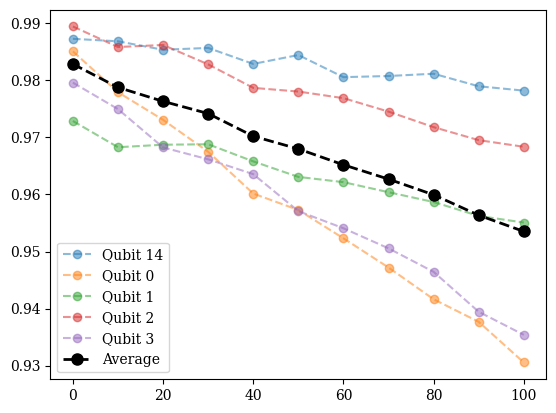

In [12]:
for qubit, evals in all_evals.items():
    plt.plot(depths, evals, "--o", alpha=0.5, label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths, evals_raw_avg, "--o", ms=8, lw=2, color="black", label="Average")
plt.legend();
# plt.savefig("physical_evals.pdf")

# Run encoded experiment

In [13]:
generator_strs = [
    "XZZXI",
    "IXZZX",
    "XIXZZ",
    "ZXIXZ",
]
# generator_strs = [
#     "ZXIXZ",
#     "XZZXI",
#     "IXZZX",
#     "XIXZZ",
# ]
observable = PauliString("Z" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_elements = generate_stabilizer_elements(stabilizer_generators)
for stab in stabilizer_elements:
    print(stab)

observable_elements = [stab * observable for stab in stabilizer_elements]
for obs in observable_elements:
    print(obs)

I
X(q(0))*Z(q(1))*Z(q(2))*X(q(3))
X(q(1))*Z(q(2))*Z(q(3))*X(q(4))
X(q(0))*X(q(2))*Z(q(3))*Z(q(4))
Z(q(0))*X(q(1))*X(q(3))*Z(q(4))
X(q(0))*Y(q(1))*Y(q(3))*X(q(4))
Z(q(1))*Y(q(2))*Y(q(3))*Z(q(4))
Y(q(0))*Y(q(1))*Z(q(2))*Z(q(4))
X(q(0))*X(q(1))*Y(q(2))*Y(q(4))
Z(q(0))*Z(q(2))*Y(q(3))*Y(q(4))
Y(q(0))*X(q(1))*X(q(2))*Y(q(3))
Y(q(1))*X(q(2))*X(q(3))*Y(q(4))
Y(q(0))*Z(q(1))*Z(q(3))*Y(q(4))
Z(q(0))*Y(q(1))*Y(q(2))*Z(q(3))
Y(q(0))*Y(q(2))*X(q(3))*X(q(4))
Z(q(0))*Z(q(1))*X(q(2))*X(q(4))
Z(q(0))*Z(q(1))*Z(q(2))*Z(q(3))*Z(q(4))
-Y(q(0))*Y(q(3))*Z(q(4))
-Z(q(0))*Y(q(1))*Y(q(4))
-Y(q(0))*Z(q(1))*Y(q(2))
-Y(q(1))*Z(q(2))*Y(q(3))
Y(q(0))*X(q(1))*Z(q(2))*X(q(3))*Y(q(4))
-Z(q(0))*X(q(2))*X(q(3))
-X(q(0))*X(q(1))*Z(q(3))
Y(q(0))*Y(q(1))*X(q(2))*Z(q(3))*X(q(4))
-Z(q(1))*X(q(3))*X(q(4))
X(q(0))*Y(q(1))*Y(q(2))*X(q(3))*Z(q(4))
Z(q(0))*X(q(1))*Y(q(2))*Y(q(3))*X(q(4))
-X(q(0))*Z(q(2))*X(q(4))
-X(q(1))*X(q(2))*Z(q(4))
X(q(0))*Z(q(1))*X(q(2))*Y(q(3))*Y(q(4))
-Y(q(2))*Z(q(3))*Y(q(4))


In [14]:
qreg = cirq.LineQubit.range(n)
circuit = encode_five(qreg)

print(circuit)

# Hacky fix to replace non-unitary RX gates at the start of the Stim circuit to Hadamard gates.
circuit = cirq.Circuit(
    cirq.H.on_each(qreg),
    circuit[1:],
)
# circuit.append(cirq.H.on_each(qreg))
circuit

0: ───RX───@───@───────────────H───X───
           │   │
1: ───RX───┼───┼───@───@───────H───X───
           │   │   │   │
2: ───RX───@───┼───┼───┼───@───H───X───
               │   │   │   │
3: ───RX───────@───@───┼───┼───H───X───
                       │   │
4: ───RX───────────────@───@───H───X───


0: ───H───@───@───────────────H───X───
          │   │
1: ───H───┼───┼───@───@───────H───X───
          │   │   │   │
2: ───H───@───┼───┼───┼───@───H───X───
              │   │   │   │
3: ───H───────@───@───┼───┼───H───X───
                      │   │
4: ───H───────────────@───@───H───X───

In [15]:
psi = circuit.final_state_vector()

for observable in observable_elements:
    O = observable.matrix(qubits=qreg)
    assert np.isclose(psi.conj().T @ O @ psi, 1.0)

for observable in stabilizer_elements:
    O = observable.matrix(qubits=qreg)
    assert np.isclose(psi.conj().T @ O @ psi, 1.0)

## Compute the numerator ($\langle \tilde{O} \rangle$)

In [16]:
num_circuits = []
for pauli in observable_elements:
    c = circuit.copy()
    print(pauli)
    for q, p in pauli.items():
        if p is cirq.X:
            c.append(cirq.H.on(q))
        elif p is cirq.Y:
            c.append(cirq.S.on(q)**-1)
            c.append(cirq.H.on(q))
    c.append(cirq.measure(qreg, key="z"))
    # print(c)
    num_circuits.append(c)

Z(q(0))*Z(q(1))*Z(q(2))*Z(q(3))*Z(q(4))
-Y(q(0))*Y(q(3))*Z(q(4))
-Z(q(0))*Y(q(1))*Y(q(4))
-Y(q(0))*Z(q(1))*Y(q(2))
-Y(q(1))*Z(q(2))*Y(q(3))
Y(q(0))*X(q(1))*Z(q(2))*X(q(3))*Y(q(4))
-Z(q(0))*X(q(2))*X(q(3))
-X(q(0))*X(q(1))*Z(q(3))
Y(q(0))*Y(q(1))*X(q(2))*Z(q(3))*X(q(4))
-Z(q(1))*X(q(3))*X(q(4))
X(q(0))*Y(q(1))*Y(q(2))*X(q(3))*Z(q(4))
Z(q(0))*X(q(1))*Y(q(2))*Y(q(3))*X(q(4))
-X(q(0))*Z(q(2))*X(q(4))
-X(q(1))*X(q(2))*Z(q(4))
X(q(0))*Z(q(1))*X(q(2))*Y(q(3))*Y(q(4))
-Y(q(2))*Z(q(3))*Y(q(4))


In [17]:
evals_numerator = []
for pauli, circuit in zip(observable_elements, num_circuits):
    # print(pauli)
    result = cirq.Simulator().run(circuit, repetitions=nshots)
    counts = result.histogram(key="z")
    counts = {int_to_bin_str(key, n) : val for key, val in counts.items()}
    eval = compute_expectation(pauli, counts)
    print(eval)
    evals_numerator.append(eval)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [18]:
evals_numerator

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [19]:
sum(evals_numerator)

16.0

## To Qiskit

In [20]:
circuit = num_circuits[-1]
circuit

0: ───H───@───@───────────────H───X──────────────M('z')───
          │   │                                  │
1: ───H───┼───┼───@───@───────H───X──────────────M────────
          │   │   │   │                          │
2: ───H───@───┼───┼───┼───@───H───X───S^-1───H───M────────
              │   │   │   │                      │
3: ───H───────@───@───┼───┼───H───X──────────────M────────
                      │   │                      │
4: ───H───────────────@───@───H───X───S^-1───H───M────────

In [21]:
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
circuit.draw(fold=-1)

┌───┐      ┌───┐┌───┐               ┌─┐                                 
  q_0: ┤ H ├─■──■─┤ H ├┤ X ├───────────────┤M├─────────────────────────────────
       ├───┤ │  │ └───┘└───┘┌───┐┌───┐     └╥┘            ┌─┐                  
  q_1: ┤ H ├─┼──┼───■────■──┤ H ├┤ X ├──────╫─────────────┤M├──────────────────
       ├───┤ │  │   │    │  └───┘└───┘┌───┐ ║ ┌───┐┌─────┐└╥┘ ┌───┐      ┌─┐   
  q_2: ┤ H ├─■──┼───┼────┼─────────■──┤ H ├─╫─┤ X ├┤ Sdg ├─╫──┤ H ├──────┤M├───
       ├───┤    │   │    │  ┌───┐  │  ├───┤ ║ └┬─┬┘└─────┘ ║  └───┘      └╥┘   
  q_3: ┤ H ├────■───■────┼──┤ H ├──┼──┤ X ├─╫──┤M├─────────╫──────────────╫────
       ├───┤             │  └───┘  │  ├───┤ ║  └╥┘  ┌───┐  ║ ┌─────┐┌───┐ ║ ┌─┐
  q_4: ┤ H ├─────────────■─────────■──┤ H ├─╫───╫───┤ X ├──╫─┤ Sdg ├┤ H ├─╫─┤M├
       └───┘                          └───┘ ║   ║   └───┘  ║ └─────┘└───┘ ║ └╥┘
m_z: 5/═════════════════════════════════════╩═══╩══════════╩══════════════╩══╩═
                                            0   3          1              2  4

In [22]:
compiled = qiskit.transpile(circuit, backend=computer, initial_layout=layout[n], optimization_level=3)

In [23]:
compiled.draw(fold=-1, idle_wires=False)

global phase: π/4
          ┌─────────┐┌────┐                ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐  ┌───┐   ┌─────────┐            ┌──────┐ ┌────────┐    ┌────┐     ┌──────────┐                                                           ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────────┐            ┌──────┐┌──────────┐   ┌───┐                                                                                                                      ┌──────┐  ┌─────────┐  ┌────┐    ┌──────────┐              ┌─┐                                                                                                                                                                         
 q_1 -> 0 ┤ Rz(π/2) ├┤ √X ├────────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├──┤ X ├───┤ Rz(π/2) ├────────────┤0     ├─┤ Rz(-π) ├────┤ √X ├─────┤ Rz(-π/2) ├───────────────────────────────────────────────────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(-π) ├────────────┤0     ├┤ Rz(-π/2) ├───┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──┤ Rz(π/2) ├──┤ √X ├────┤ Rz(-π/2) ├──────────────┤M├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          ├─────────┤├────┤   ┌────────┐   │  Ecr │├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │┌─┴───┴──┐└──┬────┬─┘┌──────────┐│      │ └┬──────┬┘ ┌──┴────┴──┐  └──┬────┬──┘ ┌────────┐  ┌──────┐ ┌─────────┐ ┌────┐┌─────────┐┌──────┐│  Ecr │├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │└─┬───┬──┘┌──────────┐│      │└─┬──────┬─┘┌──┴───┴───┐     ┌────┐    ┌────────┐  ┌──────┐ ┌─────────┐ ┌────┐┌─────────┐┌──────┐┌─────────────┐   ┌────┐   ┌──────────┐  │  Ecr │  ├─────────┤  ├────┤  ┌─┴──────────┴─┐            └╥┘                                                                    ┌──────┐ ┌─────────┐ ┌────┐  ┌─────────┐          ┌─┐                                                
 q_2 -> 1 ┤ Rz(π/2) ├┤ √X ├───┤ Rz(-π) ├───┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├┤ Rz(-π) ├───┤ √X ├──┤ Rz(-π/2) ├┤      ├──┤0     ├──┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(-π) ├──┤0     ├─┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├──┤ X ├───┤ Rz(-π/2) ├┤      ├──┤0     ├──┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(-π) ├──┤0     ├─┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(-2.2791) ├───┤ √X ├───┤ Rz(-π/2) ├──┤1     ├──┤ Rz(π/2) ├──┤ √X ├──┤ Rz(-0.70826) ├─────────────╫─────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(π/2) ├─┤ √X ├──┤ Rz(π/2) ├──────────┤M├────────────────────────────────────────────────
          ├─────────┤├────┤   ├────────┤   └──────┘└─────────┘ └────┘          └──────┘└──────────┘                 └──────┘└────────┘   └────┘  └──────────┘│      │  │  Ecr │  ├─────────┬┘     ├────┤    └────────┘  │  Ecr │ ├─────────┴┐└────┘└─────────┘│  Ecr │└┬────┬┘└─────────┘ └────┘          └──────┘└──────────┘                 └──────┘  └───┘   └──────────┘│      │  │  Ecr │  ├─────────┬┘     ├────┤    └────────┘  │  Ecr │ ├─────────┴┐└────┘└─────────┘│  Ecr │└────┬───┬────┘┌──┴────┴──┐└─┬──────┬─┘┌─┴──────┴─┐└──┬────┬─┘┌─┴────┴─┐└───┬──────┬───┘┌─────────┐  ║ ┌────┐┌─────────┐┌──────┐┌────────────┐     ┌────┐    ┌──────────┐  │  Ecr │ ├─────────┴┐├────┤┌─┴─────────┴─┐┌──────┐└╥┘   ┌────┐  ┌────────┐               ┌─┐         
 q_3 -> 2 ┤ Rz(π/2) ├┤ √X ├───┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤  Ecr ├──┤1     ├──┤ Rz(π/2) ├──────┤ √X ├────────────────┤1     ├─┤ Rz(-π/2) ├─────────────────┤1     ├─┤ √X

In [24]:
from qiskit.transpiler.passes import RemoveFinalMeasurements

In [25]:
compiled = RemoveFinalMeasurements()(compiled)
compiled.measure_active()

In [26]:
compiled.draw(fold=-1, idle_wires=False)

global phase: π/4
           ┌─────────┐┌────┐                ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐  ┌───┐   ┌─────────┐            ┌──────┐ ┌────────┐    ┌────┐     ┌──────────┐                                                           ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────────┐            ┌──────┐┌──────────┐   ┌───┐                                                                                                                      ┌──────┐  ┌─────────┐  ┌────┐    ┌──────────┐                                                                                                                                                                               ░ ┌─┐            
      q_0: ┤ Rz(π/2) ├┤ √X ├────────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├──┤ X ├───┤ Rz(π/2) ├────────────┤0     ├─┤ Rz(-π) ├────┤ √X ├─────┤ Rz(-π/2) ├───────────────────────────────────────────────────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(-π) ├────────────┤0     ├┤ Rz(-π/2) ├───┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──┤ Rz(π/2) ├──┤ √X ├────┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├────────────
           ├─────────┤├────┤   ┌────────┐   │  Ecr │├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │┌─┴───┴──┐└──┬────┬─┘┌──────────┐│      │ └┬──────┬┘ ┌──┴────┴──┐  └──┬────┬──┘ ┌────────┐  ┌──────┐ ┌─────────┐ ┌────┐┌─────────┐┌──────┐│  Ecr │├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │└─┬───┬──┘┌──────────┐│      │└─┬──────┬─┘┌──┴───┴───┐     ┌────┐    ┌────────┐  ┌──────┐ ┌─────────┐ ┌────┐┌─────────┐┌──────┐┌─────────────┐   ┌────┐   ┌──────────┐  │  Ecr │  ├─────────┤  ├────┤  ┌─┴──────────┴─┐                                                                                ┌──────┐ ┌─────────┐ ┌────┐  ┌─────────┐                                                     ░ └╥┘┌─┐         
      q_1: ┤ Rz(π/2) ├┤ √X ├───┤ Rz(-π) ├───┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├┤ Rz(-π) ├───┤ √X ├──┤ Rz(-π/2) ├┤      ├──┤0     ├──┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(-π) ├──┤0     ├─┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├──┤ X ├───┤ Rz(-π/2) ├┤      ├──┤0     ├──┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(-π) ├──┤0     ├─┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(-2.2791) ├───┤ √X ├───┤ Rz(-π/2) ├──┤1     ├──┤ Rz(π/2) ├──┤ √X ├──┤ Rz(-0.70826) ├────────────────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(π/2) ├─┤ √X ├──┤ Rz(π/2) ├─────────────────────────────────────────────────────░──╫─┤M├─────────
           ├─────────┤├────┤   ├────────┤   └──────┘└─────────┘ └────┘          └──────┘└──────────┘                 └──────┘└────────┘   └────┘  └──────────┘│      │  │  Ecr │  ├─────────┬┘     ├────┤    └────────┘  │  Ecr │ ├─────────┴┐└────┘└─────────┘│  Ecr │└┬────┬┘└─────────┘ └────┘          └──────┘└──────────┘                 └──────┘  └───┘   └──────────┘│      │  │  Ecr │  ├─────────┬┘     ├────┤    └────────┘  │  Ecr │ ├─────────┴┐└────┘└─────────┘│  Ecr │└────┬───┬────┘┌──┴────┴──┐└─┬──────┬─┘┌─┴──────┴─┐└──┬────┬─┘┌─┴────┴─┐└───┬──────┬───┘┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────────────┐     ┌────┐    ┌──────────┐  │  Ecr │ ├─────────┴┐├────┤┌─┴─────────┴─┐┌──────┐   ┌────┐  ┌────────┐                      ░  ║ └╥┘┌─┐      
      q_2: ┤ Rz(π/2) ├┤ √X ├───┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤  Ecr ├──┤1     ├──┤ Rz(π/2) ├──────┤ √X ├────────────────┤1     ├─┤ Rz(-

In [27]:
sampler.run([compiled], shots=nshots)

## Compute the denominator

In [28]:
den_circuits = []
for pauli in stabilizer_elements:
    c = circuit.copy()
    for q, p in pauli.items():
        if p is cirq.X:
            c.append(cirq.H.on(q))
        elif p is cirq.Y:
            c.append(cirq.S.on(q)**-1)
            c.append(cirq.H.on(q))
    # c = c.with_noise(cirq.depolarize(p=noise_rate))
    c.append(cirq.measure(qreg, key="z"))
    den_circuits.append(c)

TypeError: issubclass() arg 1 must be a class

In [29]:
evals_denominator = []
for pauli, circuit in zip(observable_elements, num_circuits):
    # print(pauli)
    result = cirq.Simulator().run(circuit, repetitions=nshots)
    counts = result.histogram(key="z")
    counts = {int_to_bin_str(key, n) : val for key, val in counts.items()}
    eval = compute_expectation(pauli, counts)
    print(eval)
    evals_denominator.append(eval)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [30]:
evals_denominator

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [31]:
sum(evals_denominator)

16.0

In [32]:
sum(evals_numerator) / sum(evals_denominator)

1.0

## With DD

In [33]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [34]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)
# job_dd = service.job("cuajqq8tk14s73b60n20")

NameError: name 'to_run' is not defined

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
evals_dd = [get_lst_ev(counts, observable_elements, stabilizer_elements) for counts in all_counts_dd]
evals_dd

## Plot data

In [22]:
save_key = f"memory_five_qubit_code_zero_state_z_{computer.name}_{time_key}_job_raw_id_{job_raw.job_id()}_job_encoded_id_{job.job_id()}_job_encoded_dd_id_{job_dd.job_id()}"

In [ ]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75

plt.axhline(1.0, label="Ideal", alpha=alpha, color="xkcd:darkgreen")
plt.plot(depths, evals_raw_avg, "--o", alpha=alpha, label="Physical (Average)")
# plt.plot(depths, all_evals[121], "--o", alpha=alpha, label="Physical (Best)")
plt.plot(depths, evals_encoded, "--o", alpha=alpha, label="Encoded")
plt.plot(depths, evals_dd, "--o", alpha=alpha, label="Encoded + DD")

plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")

plt.legend();
plt.savefig(save_key + ".pdf")

## Save all data

In [24]:
import os

import pickle

In [25]:
os.mkdir(save_key)

In [26]:
np.savetxt(f"{save_key}/physical_qubits.txt", layout[n])
np.savetxt(f"{save_key}/depths.txt", depths)

In [27]:
with open(f"{save_key}/expectation_values_raw.pkl", "wb") as f:
    pickle.dump(all_evals, f)

In [28]:
np.savetxt(f"{save_key}/expectation_values_encoded.txt", evals_encoded)
np.savetxt(f"{save_key}/expectation_values_encoded_dd.txt", evals_dd)